![Fixel Algorithms](https://fixelalgorithms.co/images/CCExt.png)

# <center> Machine Learning Methods </center>
## <center> Lecture 28 - PyTorch</center>
### <center> TensorBoard</center>

Colab users should use GPU runtime:
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/FixelAlgorithmsTeam/FixelCourses/blob/master/DeepLearningMethods/07_PyTorch/MainPyTorchSchdulers.ipynb)

In [1]:
#-- Wide screen:
# from IPython.core.display import display, HTML
# display(HTML("<style>.container { width:80% !important; }</style>"))

In [2]:
#-- Auto reload:
%load_ext autoreload
%autoreload 2

In [3]:
#-- Imports:
import numpy             as np
import pandas            as pd
import matplotlib.pyplot as plt
import matplotlib

matplotlib.rc('font', **{'size' : 16})

#-- torch:
import torch

#-- Fix seed (for presentation sake)
torch.manual_seed(3)
np.random.seed(3)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark     = False

### Load Fashion-MNIST data:

In [4]:
import torchvision
import torchvision.transforms as transforms

oTransform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

oTrainSet = torchvision.datasets.FashionMNIST('../../data', download=True, train=True,  transform=oTransform)
oTestSet  = torchvision.datasets.FashionMNIST('../../data', download=True, train=False, transform=oTransform)

oTrainDL  = torch.utils.data.DataLoader(oTrainSet, batch_size=1024, shuffle=True,  num_workers=2)
oTestDL   = torch.utils.data.DataLoader(oTestSet,  batch_size=1024, shuffle=False, num_workers=2)

lClasses  = oTrainSet.classes

### Plot some examples:

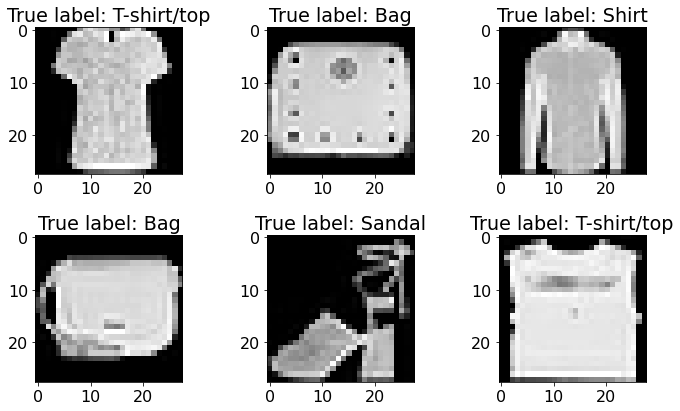

In [5]:
N, H, W = oTrainSet.data.shape
fig, _  = plt.subplots(2, 3, figsize=(10,6))
for ax in fig.axes:
    idx   = np.random.randint(0, N)
    mX, y = oTrainSet[idx]
    mX    = mX.squeeze() * 0.5 + 0.5
    mX    = torch.clamp(mX, 0, 1)
    ax.imshow(mX, cmap='gray')
    ax.set_title('True label: ' + str(lClasses[y]))
    
plt.tight_layout()
plt.show()

### Define a model:

In [6]:
import torchsummary
import torch.nn            as nn
import torch.nn.functional as F
import torch.optim         as optim

#--------------------------------------------------------------------------------#
#--------------------------------------------------------------------------------#
def WeightInit(oModule):
    if isinstance(oModule, nn.Conv2d):
        nn.init.kaiming_normal_(oModule.weight.data)

#--------------------------------------------------------------------------------#
#--------------------------------------------------------------------------------#
#-- Tensor to vector (reshape):
class Flatten(nn.Module):
    def forward(self, mX):
        N  = mX.shape[0]
        mZ = mX.view(N, -1)
        return mZ

In [7]:
#-- Model:
def GetModel():
    oModel = nn.Sequential(
        nn.Sequential(), #-- does nothing
        
        nn.Conv2d(1,  5,  5), nn.LeakyReLU(),
        nn.Conv2d(5,  10, 5), nn.LeakyReLU(),
        nn.Conv2d(10, 10, 5), nn.LeakyReLU(),
        nn.Conv2d(10, 5,  5), nn.LeakyReLU(),
        nn.Conv2d(5,  5,  5), nn.LeakyReLU(),
        
        Flatten(),
        nn.Linear(320, 10)
    )
    oModel.apply(WeightInit)
    return oModel

#--------------------------------------------------------------------------------#
#--------------------------------------------------------------------------------#
torchsummary.summary(GetModel(), (1, H, W), device='cpu')
print()

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 1, 28, 28]           --
├─Conv2d: 1-2                            [-1, 5, 24, 24]           130
├─LeakyReLU: 1-3                         [-1, 5, 24, 24]           --
├─Conv2d: 1-4                            [-1, 10, 20, 20]          1,260
├─LeakyReLU: 1-5                         [-1, 10, 20, 20]          --
├─Conv2d: 1-6                            [-1, 10, 16, 16]          2,510
├─LeakyReLU: 1-7                         [-1, 10, 16, 16]          --
├─Conv2d: 1-8                            [-1, 5, 12, 12]           1,255
├─LeakyReLU: 1-9                         [-1, 5, 12, 12]           --
├─Conv2d: 1-10                           [-1, 5, 8, 8]             630
├─LeakyReLU: 1-11                        [-1, 5, 8, 8]             --
├─Flatten: 1-12                          [-1, 320]                 --
├─Linear: 1-13                           [-1, 10]                  3,210
T

### Define a TensorBoard writing object:

In [8]:
from torch.utils.tensorboard import SummaryWriter

# default `log_dir` is `runs`
oWriter = SummaryWriter('runs/Run1')

cmd (from the same path as this file):  
`tensorboard --logdir=runs`  
go to:  
http://localhost:6006/

### Write some training images to TensorBoard:

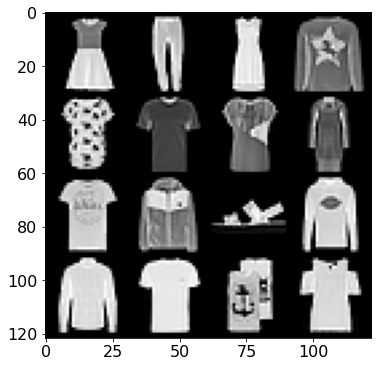

In [9]:
mX          = next(iter(oTrainDL))[0][:16]
mImagesGrid = torchvision.utils.make_grid(mX * 0.5 + 0.5, nrow=4)   #-- 4 x 4 grid
plt.figure(figsize=(8,6))
plt.imshow(mImagesGrid.numpy().transpose((1,2,0)))
plt.show()

#-- write to tensorboard
oWriter.add_image('Training images', mImagesGrid)
# oWriter.close()

### Write the model's graph to TensorBoard:

In [10]:
oModel = GetModel()
oWriter.add_graph(oModel, mX)
oWriter.close()

### Upload embeddings to TensorBoard:

In [11]:
#-- A way to get N (random) data points:
N         = 1000
oTrainDL2 = torch.utils.data.DataLoader(oTrainSet, batch_size=N, shuffle=True)
mX, vY    = next(iter(oTrainDL2))
lLabels   = [lClasses[y] for y in vY]

#-- Add embeddings to TensorBoard:
mFeatures = mX.view(N, -1)
oWriter.add_embedding(mFeatures, metadata=lLabels, label_img=1-mX, tag='Raw data')
oWriter.close()
#-- if data do not apper in TensorBoard, reconnect in the cmd.

### A function to plot a sample with its label prediction:

In [14]:
def PlotImages(oModel, mX, vY):
    N     = mX.shape[0]
    mP    = torch.softmax(oModel(mX), dim=1)
    vHatY = torch.argmax(mP, dim=1)
    vP    = mP[range(N),vHatY]
    
    fig, _ = plt.subplots(1, 4, figsize=(12, 8))
    for ii, ax in enumerate(fig.axes):
        if vHatY[ii] == vY[ii]:
            color = 'g'
        else:
            color = 'r'
        
        label     = lClasses[vY[ii]]
        labelHat  = lClasses[vHatY[ii]]
        ax.imshow(mX[ii].squeeze().cpu() * 0.5 + 0.5, cmap='gray')        
        ax.set_title(f'{labelHat}, {100 * vP[ii]:.1f}%\n'
                     f'(True label: {label})', color=color)
        plt.tight_layout()
    return fig

### Device, optimizer and loss functions:

In [15]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") 
device

device(type='cuda', index=0)

In [16]:
oModel.to(device)
oOptim   = optim.SGD(oModel.parameters(), lr=3e-2, momentum=.5)
LossFunc = nn.CrossEntropyLoss()

### A simple training loop that write losses to TensorBoard:
It also write a few prediction at each epoch.

In [17]:
import time

numEpochs = 10
ii        = 0
for epoch in range(numEpochs):
    startTime = time.time()
    epochLoss = 0
    count     = 0 

    for mX, vY in oTrainDL:
        mX = mX.to(device) #-- move to device (CPU\GPU)
        vY = vY.to(device) #-- move to device (CPU\GPU)

        # forward + backward + optimize
        oOptim.zero_grad()
        mHatY = oModel(mX)
        loss  = LossFunc(mHatY, vY)
        loss.backward()
        oOptim.step()

        Nb         = mX.shape[0]
        epochLoss += Nb * loss.item()
        count     += Nb
        
        oWriter.add_scalars('Training loss (per iteration)', {'batch loss': loss.item()}, global_step=ii)
        oWriter.flush()
        ii += 1
        
    epochLoss /= count
    
    endTime = time.time()
    print('Epoch '              f'{epoch:3d}:',                  end='')
    print(' | Train loss: '     f'{epochLoss:.5f}',              end='')
    print(' | epoch time: '     f'{(endTime-startTime):3.3f} |')
        
    oWriter.add_scalars('Training loss (per iteration)', {'epoch loss': epochLoss},  global_step=ii)
    oWriter.add_scalar('Training loss (per epoch)',      epochLoss,                  global_step=epoch)
    oWriter.add_figure('Accuracy',                       PlotImages(oModel, mX, vY), global_step=epoch)

oWriter.close()

Epoch   0: | Train loss: 1.99538 | epoch time: 6.851 |
Epoch   1: | Train loss: 1.19872 | epoch time: 5.984 |
Epoch   2: | Train loss: 0.80526 | epoch time: 6.368 |
Epoch   3: | Train loss: 0.71715 | epoch time: 5.730 |
Epoch   4: | Train loss: 0.67214 | epoch time: 5.846 |
Epoch   5: | Train loss: 0.64710 | epoch time: 5.913 |
Epoch   6: | Train loss: 0.61929 | epoch time: 5.469 |
Epoch   7: | Train loss: 0.59302 | epoch time: 5.531 |
Epoch   8: | Train loss: 0.57911 | epoch time: 5.678 |
Epoch   9: | Train loss: 0.56065 | epoch time: 5.485 |


### Same as before, but as a function:

In [18]:
def TrainModel(oModel, oTrainDL, oOptim, numEpochs, oWriter):

    ii = 0
    for epoch in range(numEpochs):  # loop over the dataset multiple times
        startTime = time.time()
        epochLoss = 0
        count     = 0 

        for mX, vY in oTrainDL:
            #-- Move to device (CPU\GPU):
            mX = mX.to(device)
            vY = vY.to(device)

            # forward + backward + optimize
            oOptim.zero_grad()
            mHatY = oModel(mX)
            loss  = LossFunc(mHatY, vY)
            loss.backward()
            oOptim.step()

            Nb         = mX.shape[0]
            epochLoss += Nb * loss.item()
            count     += Nb

            oWriter.add_scalar('Training loss (per iteration)', loss.item(), global_step=ii)
            oWriter.flush()
            ii += 1

        epochLoss /= count

        endTime = time.time()
        print('Epoch '              f'{epoch:3d}:',                  end='')
        print(' | Train loss: '     f'{epochLoss:.5f}',              end='')
        print(' | epoch time: '     f'{(endTime-startTime):3.3f} |')

        oWriter.add_scalar('Training loss (per epoch)', epochLoss, global_step=epoch)

    oWriter.close()

### With TensorBoard it is easy to compare between multiple configuration:
For now, we will just try multiple learning rates.

In [ ]:
lLR = [1e-3, 5e-3, 1e-2, 3e-2]

for ii, LR in enumerate(lLR):
    print('===============================================================')
    print('Train configuration ' + str(ii) + ':')
    print('===============================================================')
    oWriter = SummaryWriter('runs/Configuration' + str(ii))
    oModel  = GetModel().to(device)
    oOptim  = optim.SGD(oModel.parameters(), lr=LR, momentum=.9, nesterov=True)
    TrainModel(oModel, oTrainDL, oOptim, 10, oWriter)

Train configuration 0:
Epoch   0: | Train loss: 2.19478 | epoch time: 6.171 |
Epoch   1: | Train loss: 1.30118 | epoch time: 6.737 |
Epoch   2: | Train loss: 0.88668 | epoch time: 5.843 |
Epoch   3: | Train loss: 0.78285 | epoch time: 5.794 |
Epoch   4: | Train loss: 0.72599 | epoch time: 5.564 |
Epoch   5: | Train loss: 0.69212 | epoch time: 5.882 |
Epoch   6: | Train loss: 0.66796 | epoch time: 5.657 |
Epoch   7: | Train loss: 0.65047 | epoch time: 5.559 |
Epoch   8: | Train loss: 0.63148 | epoch time: 5.463 |
Epoch   9: | Train loss: 0.62050 | epoch time: 5.318 |
Train configuration 1:
Epoch   0: | Train loss: 1.73668 | epoch time: 5.322 |
Epoch   1: | Train loss: 0.77284 | epoch time: 5.446 |
Epoch   2: | Train loss: 0.63176 | epoch time: 5.575 |
Epoch   3: | Train loss: 0.57212 | epoch time: 5.661 |
Epoch   4: | Train loss: 0.53701 | epoch time: 5.696 |
Epoch   5: | Train loss: 0.51082 | epoch time: 5.596 |
Epoch   6: | Train loss: 0.49546 | epoch time: 5.630 |
Epoch   7: | Train 

### The End